<a href="https://colab.research.google.com/github/StudentHagal/Thesis/blob/main/Classifier_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Requirements

In [1]:
# Libraries
import sys
import pandas as pd
import hashlib
import matplotlib
import numpy as np
import sklearn
import scipy
import joblib
from matplotlib import pyplot
from collections import Counter
from imblearn.over_sampling import SMOTE
from pandas import read_csv
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from timeit import default_timer as timer

#Extension
!pip install ipython-autotime
%load_ext autotime
!git clone https://github.com/StudentHagal/Thesis.git

print('Load completed')


Cloning into 'Thesis'...
remote: Enumerating objects: 237, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (226/226), done.
remote: Total 237 (delta 87), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (237/237), 15.80 MiB | 3.50 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Load completed
time: 11.2 s (started: 2022-01-10 13:22:39 +00:00)


# Check Lib Version

In [2]:
# Check the versions of libraries
# !!! WARNING !!!
# Important because model result may be different for other version
 
print('Python: {}'.format(sys.version))
print('scipy: {}'.format(scipy.__version__))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('pandas: {}'.format(pd.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('joblib: {}'.format(joblib.__version__))

Python: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
scipy: 1.4.1
numpy: 1.19.5
matplotlib: 3.2.2
pandas: 1.1.5
sklearn: 1.0.1
joblib: 1.1.0
time: 3.47 ms (started: 2022-01-10 13:22:50 +00:00)


# Global Variables Declaration

In [3]:
# Global Variable

#Stored file path                     
raw_file = "/content/Thesis/Resources/database.csv"
#environment path         
model_dir = '/content/Thesis/Resources/models/'                                  
process_dir = '/content/Thesis/Resources/processed/'
#Column names for dataset
features = ['Oil_Pressure', 'Coolant_Temp', 'PF_Avg', 'ECU_Temp']
resampled_col = ['Oil_Pressure', 'Coolant_Temp', 'PF_Avg', 'ECU_Temp',
                 'P1',	'P2',	'P3',	'P4']
#Synthetic data generator
balancing_smote = SMOTE(random_state=1)


time: 5.92 ms (started: 2022-01-10 13:22:50 +00:00)


# Hash Check Function

In [4]:
# Function that returns the SHA-2 hash of the file
def hash_file(filepath):

   # make a hash object with SHA-2
   h = hashlib.sha256()

   # open file for reading in binary mode
   with open(filepath,'rb') as file:
       # loop till the end of the file
       chunk = 0
       while chunk != b'':
           # read only 1024 bytes at a time
           chunk = file.read(1024)
           h.update(chunk)

   # return the hex representation of digest
   return h.hexdigest()


time: 8.9 ms (started: 2022-01-10 13:22:50 +00:00)


# Prepare Dataset

## Hash Check

In [5]:
# Checking hash value of a file
message = hash_file(process_dir+'final_dataset.csv')
print('SHA-256 value of your file is :')
print(message)


SHA-256 value of your file is :
d01cb955d38d655c91fbe964767d12944271062c20f73eeea7db897046d85201
time: 31.3 ms (started: 2022-01-10 13:22:50 +00:00)


## Process Dataset

### Dataset Statistical Label

In [6]:
# Dataset for 3 label from statistical labelling (Outlier, Normal, Maintenance)

#change dataset source to 'SMOTE_statistical.csv' for resampled data, OR 'final_dataset.csv' for original
df_statistical = pd.read_csv(process_dir+'final_dataset.csv', index_col=0)
df_statistical

#split data for training and testing 
X1 = df_statistical[resampled_col]
y1 = df_statistical['Label']
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.1, random_state=1, stratify = y1)

#Training dataset 1 summary
# data size
print('Training dataset 1 size : ', X1_train.shape)
print(' ')
print('Testing dataset 1 size : ', X1_test.shape)
print(' ')
# statistical value of data
print(X1_train.describe())


Training dataset 1 size :  (30448, 8)
 
Testing dataset 1 size :  (3384, 8)
 
       Oil_Pressure  Coolant_Temp  ...            P3            P4
count  30448.000000  30448.000000  ...  30448.000000  30448.000000
mean    1583.672852    686.421473  ...     -0.000447     -0.000066
std     8283.057819   4466.419629  ...      0.122784      0.072778
min        0.000000      0.000000  ...     -0.533642     -0.705302
25%      592.000000     76.000000  ...     -0.009146     -0.015544
50%      612.000000     81.000000  ...     -0.006031     -0.012463
75%      624.000000     82.000000  ...     -0.004248     -0.009534
max    65535.000000  65531.000000  ...      0.886803      0.735992

[8 rows x 8 columns]
time: 219 ms (started: 2022-01-10 13:22:51 +00:00)


### Dataset Clustering

In [7]:
# Dataset3 for 3 label from DBSCAN clustering (0,1,2)

#change dataset source to 'SMOTE_cluster.csv' for resampled data, OR 'final_dataset.csv' for original
df_clustering = pd.read_csv(process_dir+'final_dataset.csv', index_col=0)
df_clustering

#split data for training and testing
X3 = df_clustering[resampled_col]
y3 = df_clustering['clusters_dbscan']
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.1, random_state=1, stratify = y3)

#Training dataset 3 summary
# data size
print('Training dataset 3 size : ', X3_train.shape)
print(' ')
print('Testing dataset 3 size : ', X3_test.shape)
print(' ')
# statistical value of data
print(df_clustering.describe())

Training dataset 3 size :  (30448, 8)
 
Testing dataset 3 size :  (3384, 8)
 
                 L1          KVAr  ...            P3            P4
count  33832.000000  3.383200e+04  ...  3.383200e+04  3.383200e+04
mean     104.661208  2.567771e+04  ...  5.966788e-17 -9.531996e-17
std       79.092619  3.308827e+05  ...  1.223393e-01  7.218916e-02
min        0.000000  0.000000e+00  ... -5.336419e-01 -7.053018e-01
25%       39.000000  9.680000e+00  ... -9.168590e-03 -1.544291e-02
50%      104.000000  3.354000e+01  ... -6.033813e-03 -1.242664e-02
75%      159.000000  5.388000e+01  ... -4.248911e-03 -9.526722e-03
max      555.000000  4.294967e+06  ...  8.868034e-01  7.359918e-01

[8 rows x 13 columns]
time: 199 ms (started: 2022-01-10 13:22:51 +00:00)


# Classifier Result

## Rule-based

### Dataset Statistical Label

Training Dataset

In [8]:
# calculate the outlier cutoff per-feature (value change depends on dataset used)

#Threshold value variable 25% min, 75% max
oil_q25, oil_q75 = X1_train.Oil_Pressure.quantile([0.25 , 0.75])
coolant_q25, coolant_q75 = X1_train.Coolant_Temp.quantile([0.25 , 0.75])
pf_q25, pf_q75 = X1_train.PF_Avg.quantile([0.25 , 0.75])
ecu_q25, ecu_q75 = X1_train.ECU_Temp.quantile([0.25 , 0.75])
#feature 1
oil_cut_off = (oil_q75 - oil_q25)*1.5
oil_lower, oil_upper = oil_q25 - oil_cut_off, oil_q75 + oil_cut_off
#feature 2
coolant_cut_off = (coolant_q75 - coolant_q25)*1.5
coolant_lower, coolant_upper = coolant_q25 - coolant_cut_off, coolant_q75 + coolant_cut_off
#feature 3
pf_cut_off = (pf_q75 - pf_q25)*1.5
pf_lower, pf_upper = pf_q25 - pf_cut_off, pf_q75 + pf_cut_off
#feature 4
ecu_cut_off = (ecu_q75 - ecu_q25)*1.5
ecu_lower, ecu_upper = ecu_q25 - ecu_cut_off, ecu_q75 + ecu_cut_off

#Print quantile value for label threshold
print('Threshold values (25%, 75%) :')
print('Oil_Pressure  = ', [oil_q25, oil_q75])
print('Coolant_Temp  = ', [coolant_q25, coolant_q75])
print('PF_Avg        = ', [pf_q25, pf_q75])
print('ECU_Temp      = ', [ecu_q25, ecu_q75])
print('')
print('Lower & Upper Threshold values :')
print('Oil_Pressure  = ', [oil_lower, oil_upper])
print('Coolant_Temp  = ', [coolant_lower,coolant_upper])
print('PF_Avg        = ', [pf_lower, pf_upper])
print('ECU_Temp      = ', [ecu_lower, ecu_upper])

Threshold values (25%, 75%) :
Oil_Pressure  =  [592.0, 624.0]
Coolant_Temp  =  [76.0, 82.0]
PF_Avg        =  [0.78, 0.89]
ECU_Temp      =  [36.0, 48.0]

Lower & Upper Threshold values :
Oil_Pressure  =  [544.0, 672.0]
Coolant_Temp  =  [67.0, 91.0]
PF_Avg        =  [0.615, 1.055]
ECU_Temp      =  [18.0, 66.0]
time: 37 ms (started: 2022-01-10 13:22:51 +00:00)


In [9]:
#Change df_dataset if using other source

#Stat_Outlier = (value < q25 - (q75-q25) * 1.5) or (value > q75 + (q75-q25) * 1.5)
Outlier_Oil = (df_statistical['Oil_Pressure'] < oil_lower) | (df_statistical['Oil_Pressure'] > oil_upper)
Outlier_Coolant =(df_statistical['Coolant_Temp'] < coolant_lower) | (df_statistical['Coolant_Temp'] > coolant_upper) 
Outlier_ECU = (df_statistical['ECU_Temp'] < ecu_lower) | (df_statistical['ECU_Temp'] > ecu_upper) 
Outlier_PFA = (df_statistical['PF_Avg'] < pf_lower) | (df_statistical['PF_Avg'] > pf_upper)

#Stat_Maintenance = (q25 - (q75-q25) * 1.5 <= value <= q25) or (q75 <= value <= q75 + (q75-q25) * 1.5)
Maintenance_Oil = (df_statistical['Oil_Pressure'].between(oil_lower, oil_q25)) | (df_statistical['Oil_Pressure'].between(oil_q75, oil_upper))
Maintenance_Coolant = (df_statistical['Coolant_Temp'].between(coolant_lower, coolant_q25)) | (df_statistical['Coolant_Temp'].between(coolant_q75, coolant_upper)) 
Maintenance_ECU = (df_statistical['ECU_Temp'].between(ecu_lower, ecu_q25)) | (df_statistical['ECU_Temp'].between(ecu_q75, ecu_upper))
Maintenance_PFA = (df_statistical['PF_Avg'].between(pf_lower, pf_q25) | (df_statistical['PF_Avg'].between(pf_q75, pf_upper)))

#Stat_Normal = q25 < value < q75 
Normal_Oil = df_statistical['Oil_Pressure'].between(oil_q25, oil_q75, inclusive=False) 
Normal_Coolant = df_statistical['Coolant_Temp'].between(coolant_q25, coolant_q75, inclusive=False)
Normal_ECU = df_statistical['ECU_Temp'].between(ecu_q25, ecu_q75, inclusive=False) 
Normal_PFA = df_statistical['PF_Avg'].between(pf_q25, pf_q75, inclusive=False)

#Label Condition
Outlier =  Outlier_Oil & Outlier_Coolant & Outlier_ECU & Outlier_PFA
Maintenance = Maintenance_Oil | Maintenance_Coolant |  Maintenance_ECU | Maintenance_PFA


time: 52.8 ms (started: 2022-01-10 13:22:51 +00:00)


Label
Maintenance    21743
Normal          3972
Outlier         4733
dtype: int64
              precision    recall  f1-score   support

 Maintenance       1.00      1.00      1.00     21743
      Normal       1.00      1.00      1.00      3972
     Outlier       1.00      1.00      1.00      4733

    accuracy                           1.00     30448
   macro avg       1.00      1.00      1.00     30448
weighted avg       1.00      1.00      1.00     30448



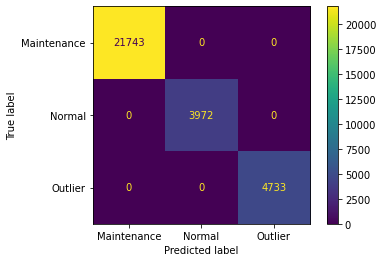

time: 1.45 s (started: 2022-01-10 13:22:51 +00:00)


In [10]:
#Check conditions for each row in dataframe

df_RBClassifier = pd.DataFrame(X1_train)
df_RBClassifier['Label'] = 'Normal'
df_RBClassifier.loc[Outlier, 'Label'] = 'Outlier'
df_RBClassifier.loc[Maintenance, 'Label'] = 'Maintenance'

# class distribution
print(df_RBClassifier.groupby('Label').size())

#Check performance of Rule-based Classifier
y_true = y1_train
y_pred = df_RBClassifier['Label']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))

Testing Dataset

Label
Maintenance    2416
Normal          442
Outlier         526
dtype: int64
              precision    recall  f1-score   support

 Maintenance       1.00      1.00      1.00      2416
      Normal       1.00      1.00      1.00       442
     Outlier       1.00      1.00      1.00       526

    accuracy                           1.00      3384
   macro avg       1.00      1.00      1.00      3384
weighted avg       1.00      1.00      1.00      3384



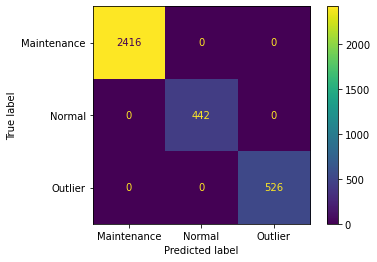

time: 333 ms (started: 2022-01-10 13:22:53 +00:00)


In [11]:
#Check conditions for each row in dataframe

df_test_rbc = pd.DataFrame(X1_test)
df_test_rbc['Label'] = 'Normal'
df_test_rbc.loc[Outlier, 'Label'] = 'Outlier'
df_test_rbc.loc[Maintenance, 'Label'] = 'Maintenance'

# class distribution
print(df_test_rbc.groupby('Label').size())

#Check performance of Rule-based Classifier
y_true = y1_test
y_pred = df_test_rbc['Label']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))

### Dataset Clustering

Training Dataset

Label_cluster
0.0     4860
1.0     1130
2.0    24458
dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4860
           1       1.00      1.00      1.00      1130
           2       1.00      1.00      1.00     24458

    accuracy                           1.00     30448
   macro avg       1.00      1.00      1.00     30448
weighted avg       1.00      1.00      1.00     30448



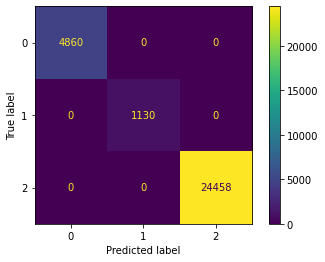

time: 282 ms (started: 2022-01-10 13:22:53 +00:00)


In [12]:
#Label Condition based on P1 and P2 Component from PCA result and clusters_dbscan

#cluster_0 = P1 > 0.25 AND P2 < 0.2
cluster_0 = (X3_train['P1'] > 0.25) & (X3_train['P2'] < 0.2)
#cluster_1 = P1 > 0.25 AND P2 > 0.2
cluster_1 = (X3_train['P1'] > 0.25) & (X3_train['P2'] > 0.2)
#cluster_2 = P1 <= 0.25 AND P2 <= 0.2
cluster_2 = (X3_train['P1'] <= 0.25) & (X3_train['P2'] <= 0.2)

#Add label to dataset
df_RBClassifier = pd.DataFrame(X3_train)
df_RBClassifier['Label_cluster'] = np.nan
df_RBClassifier.loc[cluster_0, 'Label_cluster'] = 0
df_RBClassifier.loc[cluster_1, 'Label_cluster'] = 1
df_RBClassifier.loc[cluster_2, 'Label_cluster'] = 2

# Label distribution result
print(df_RBClassifier.groupby('Label_cluster').size())

#Check performance of Rule-based Classifier
y_true = y3_train
y_pred = df_RBClassifier['Label_cluster']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))

Testing Dataset

Label_cluster
0.0     540
1.0     126
2.0    2718
dtype: int64
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       540
           1       1.00      1.00      1.00       126
           2       1.00      1.00      1.00      2718

    accuracy                           1.00      3384
   macro avg       1.00      1.00      1.00      3384
weighted avg       1.00      1.00      1.00      3384



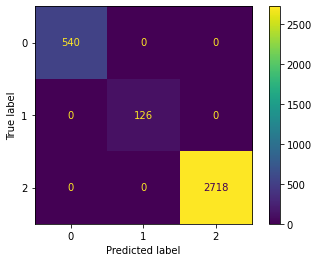

time: 222 ms (started: 2022-01-10 13:22:53 +00:00)


In [13]:
#Label Condition based on P1 and P2 Component from PCA result and clusters_dbscan

#cluster_0 = P1 > 0.25 AND P2 < 0.2
cluster_0 = (X3_test['P1'] > 0.25) & (X3_test['P2'] < 0.2)
#cluster_1 = P1 > 0.25 AND P2 > 0.2
cluster_1 = (X3_test['P1'] > 0.25) & (X3_test['P2'] > 0.2)
#cluster_2 = P1 <= 0.25 AND P2 <= 0.2
cluster_2 = (X3_test['P1'] <= 0.25) & (X3_test['P2'] <= 0.2)

#Add label to dataset
df_test_rbc = pd.DataFrame(X3_test)
df_test_rbc['Label_cluster'] = np.nan
df_test_rbc.loc[cluster_0, 'Label_cluster'] = 0
df_test_rbc.loc[cluster_1, 'Label_cluster'] = 1
df_test_rbc.loc[cluster_2, 'Label_cluster'] = 2

# Label distribution result
print(df_test_rbc.groupby('Label_cluster').size())

#Check performance of Rule-based Classifier
y_true = y3_test
y_pred = df_test_rbc['Label_cluster']
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
print(classification_report(y_true, y_pred))

## ML Algorithm

In [14]:
# ML Algorithm considered

model_LR = LogisticRegression(max_iter=1000)
model_KNN = KNeighborsClassifier()
model_DT = DecisionTreeClassifier()
model_SVM = SVC(gamma='auto')
model_RF = RandomForestClassifier()
model_LDA = LinearDiscriminantAnalysis()
model_NB = GaussianNB()
###################################################################
# save into a list for easy training & cross validation
models = []
models.append(('LR', model_LR))
models.append(('KNN', model_KNN))
models.append(('DT', model_DT))
models.append(('SVM', model_SVM))
models.append(('RF', model_RF))
models.append(('LDA', model_LDA))
models.append(('NB', model_NB))


time: 11.8 ms (started: 2022-01-10 13:22:53 +00:00)


### Dataset Statistical Label

Training Results

LR: 0.345871
Runtime (s) : 3.579376706000005
KNN: 0.986206
Runtime (s) : 2.0229288599999933
DT: 1.000000
Runtime (s) : 0.4702667740000095
SVM: 0.942171
Runtime (s) : 59.15790206
RF: 1.000000
Runtime (s) : 2.105340156000011
LDA: 0.353111
Runtime (s) : 0.5162576839999815
NB: 0.357045
Runtime (s) : 0.3514576409999961


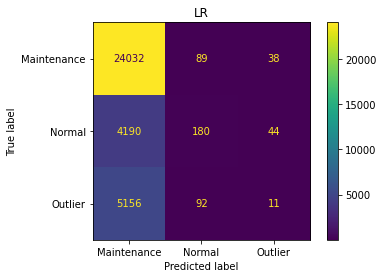

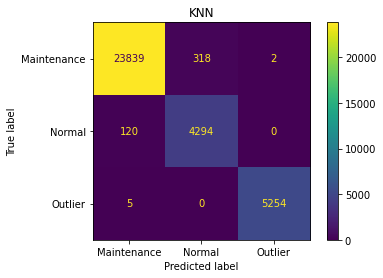

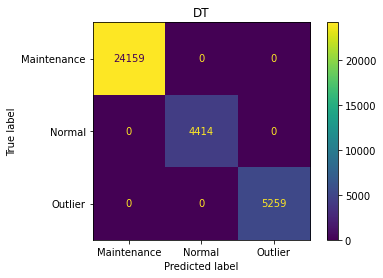

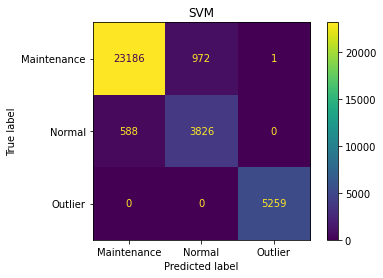

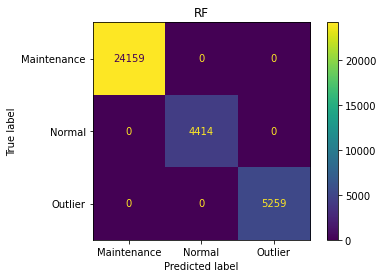

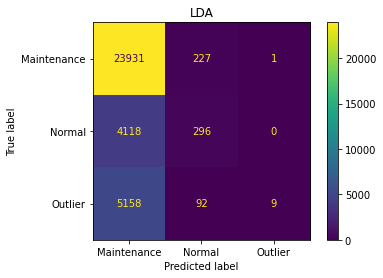

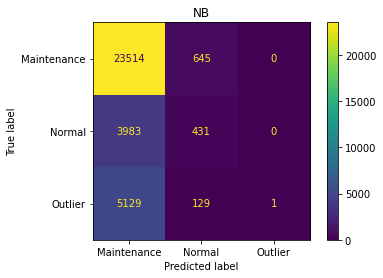

time: 1min 9s (started: 2022-01-10 13:22:53 +00:00)


In [15]:
#Loop for training ML model
fitted_models1 = []
training_results1 = []
names = []

for name, model in models:
  start = timer() #Start measure Runtime
  fitting = model.fit(df_statistical[features], df_statistical['Label']) #Fit model with dataset
  fitted_models1.append(fitting) 
  #Show metrics to evaluate performance
  pred = model.predict(df_statistical[features])
  acc = balanced_accuracy_score(df_statistical['Label'], pred)
  training_results1.append(acc)
  names.append(name)
  print('%s: %f' % (name, acc))
  ConfusionMatrixDisplay.from_predictions(df_statistical['Label'], pred)
  pyplot.title('%s' %name)
  joblib.dump(model,model_dir+'Opsi1_%s'%name) #export to external files
  end = timer() #End measure Runtime
  print('Runtime (s) :', (end - start))


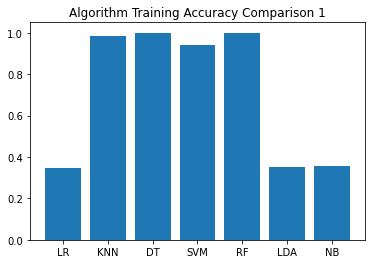

time: 238 ms (started: 2022-01-10 13:24:03 +00:00)


In [16]:
# Compare result
pyplot.bar(x=names, height=training_results1)
pyplot.title('Algorithm Training Accuracy Comparison 1')
pyplot.show()

Testing (CV) Results

LR: 0.347157 (0.003690)
Avg Runtime (s) : 2.8206225270000003
KNN: 0.977851 (0.002704)
Avg Runtime (s) : 0.22714301309999882
DT: 0.998179 (0.001022)
Avg Runtime (s) : 0.07398127210000212
SVM: 0.921251 (0.007280)
Avg Runtime (s) : 33.2630172032
RF: 0.997370 (0.000943)
Avg Runtime (s) : 1.2746250794999923
LDA: 0.352987 (0.004337)
Avg Runtime (s) : 0.15444510790000548
NB: 0.357238 (0.007420)
Avg Runtime (s) : 0.06522860200000195


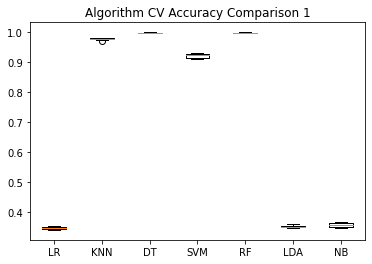

time: 6min 18s (started: 2022-01-10 13:24:03 +00:00)


In [17]:
# Loop for Cross validation of each model in turn
cv_results1 = []

#change x(features), y(labels) value in cross_val_score if using different dataset
for name, model in models:
 start = timer()
 kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
 cv_scores = cross_val_score(model, df_statistical[features], df_statistical['Label'], cv=kfold, 
                             scoring='balanced_accuracy')
 cv_results1.append(cv_scores)
 print('%s: %f (%f)' % (name, cv_scores.mean(), cv_scores.std()))
 end = timer()
 print('Avg Runtime (s) :', (end - start)/10)

# Compare result
pyplot.boxplot(cv_results1, labels=names)
pyplot.title('Algorithm CV Accuracy Comparison 1')
pyplot.show()

### Dataset Clustering

Training Results

LR: 1.000000
Runtime (s) : 12.932337565000012
KNN: 0.999407
Runtime (s) : 1.5524734549999266
DT: 1.000000
Runtime (s) : 0.0763233789999731
SVM: 1.000000
Runtime (s) : 58.608305718
RF: 1.000000
Runtime (s) : 1.4655906620000678
LDA: 0.949310
Runtime (s) : 0.14586550100000295
NB: 0.998272
Runtime (s) : 0.06413562799991723


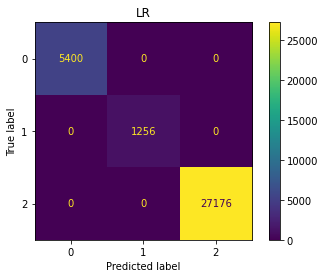

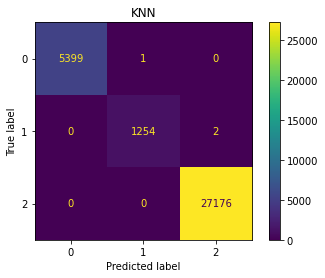

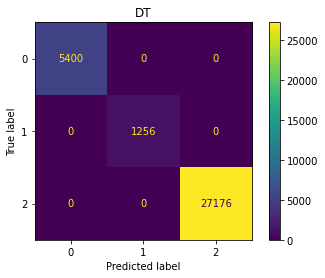

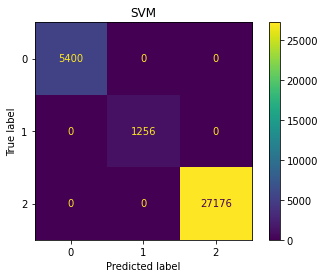

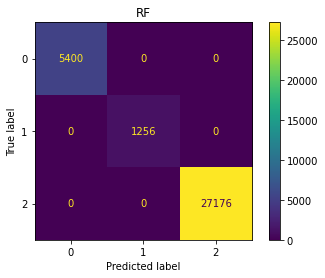

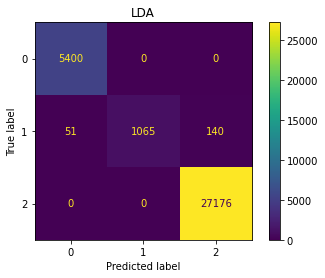

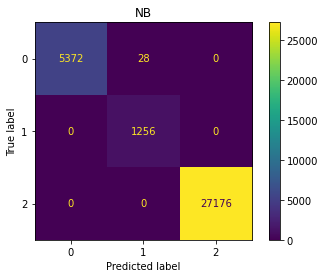

time: 1min 16s (started: 2022-01-10 13:30:22 +00:00)


In [18]:
#Loop for training ML model
fitted_models3 = []
training_results3 = []
names = []

for name, model in models:
  start = timer() #Start measure Runtime
  fitting = model.fit(df_clustering[features], df_clustering['clusters_dbscan']) #Fit model with dataset
  fitted_models3.append(fitting) 
  #Show metrics to evaluate performance
  pred = model.predict(df_clustering[features])
  acc = balanced_accuracy_score(df_clustering['clusters_dbscan'], pred)
  training_results3.append(acc)
  names.append(name)
  print('%s: %f' % (name, acc))
  ConfusionMatrixDisplay.from_predictions(df_clustering['clusters_dbscan'], pred)
  pyplot.title('%s' %name)
  joblib.dump(model,model_dir+'Opsi3_%s'%name) #export to external files
  end = timer() #End measure Runtime
  print('Runtime (s) :', (end - start))



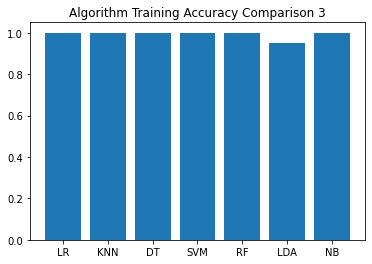

time: 139 ms (started: 2022-01-10 13:31:38 +00:00)


In [19]:
# Compare result
pyplot.bar(x=names, height=training_results3)
pyplot.title('Algorithm Training Accuracy Comparison 3')
pyplot.show()

Testing (CV) Results

LR: 0.999467 (0.001600)
Avg Runtime (s) : 15.103294799600008
KNN: 0.999407 (0.001048)
Avg Runtime (s) : 0.1781846518000066
DT: 0.999733 (0.000800)
Avg Runtime (s) : 0.024993795699992917
SVM: 0.942973 (0.011975)
Avg Runtime (s) : 39.0045477891
RF: 0.999467 (0.001600)
Avg Runtime (s) : 0.9915335428999924
LDA: 0.949304 (0.005150)
Avg Runtime (s) : 0.04742512650000208
NB: 0.998210 (0.000644)
Avg Runtime (s) : 0.01719137249999676


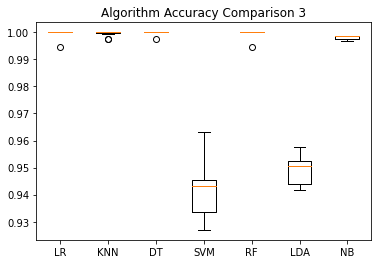

time: 9min 13s (started: 2022-01-10 13:31:38 +00:00)


In [20]:
# Loop for Cross validation of each model in turn
cv_results3 = []

#change x(features), y(labels) value in cross_val_score if using different dataset
for name, model in models:
 start = timer()
 kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
 cv_scores = cross_val_score(model, df_clustering[features], df_clustering['clusters_dbscan'], cv=kfold, 
                             scoring='balanced_accuracy')
 cv_results3.append(cv_scores)
 print('%s: %f (%f)' % (name, cv_scores.mean(), cv_scores.std()))
 end = timer()
 print('Avg Runtime (s) :', (end - start)/10)

# Compare result
pyplot.boxplot(cv_results3, labels=names)
pyplot.title('Algorithm Accuracy Comparison 3')
pyplot.show()